# Label Watches Classfier
This is a Convolutional Neural Network Which apply multi-label classfier problem to the labeling watches task.

## Import dependencies

In [26]:
# Import dependencies
from tensorflow.keras.layers import Conv2D, Input, ReLU, BatchNormalization, Dropout, MaxPooling2D, Flatten, Dense, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer


import os
import numpy as np
from matplotlib import pyplot as plt
import pathlib
import glob
import zipfile
from csv import DictReader

## Loading and preprocessing data
* You can download the dataset from https://www.kaggle.com/paramaggarwal/fashion-product-images-small
* Change _dataset_path_ value for the path to the dataset .zip file.

In [2]:
# prepare Dataset
dataset_path = (pathlib.Path.home() / 'archive.zip')
def unzip_dataset(base_path):
    if not os.path.exists(base_path):
        with (zipfile.ZipFile(dataset_path, 'r')) as zip_file:
            zip_file.extractall(base_path)
            print(f"Files extracted to {base_path}.")
    else:
        print(f"Files already extracted at {base_path}.")

In [3]:
# Utils
SEED = 42
np.random.seed(SEED)
base_path = (pathlib.Path.home() / '.keras' / 'datasets' / 'fashion-product-images-small')
style_path = str(base_path / 'styles.csv')
unzip_dataset(base_path)
image_path_pattern = str(base_path / 'images/*.jpg')
image_paths = glob.glob(image_path_pattern)

Files already extracted at C:\Users\danieldi\.keras\datasets\fashion-product-images-small.


In [4]:
# load images and labels function
def load_image_and_labels(image_paths, styles, target_size):
    images = []
    labels = []
    
    for image_path in image_paths:
        image = load_img(image_path, target_size=target_size)
        image = img_to_array(image)
        image_id = image_path.split(os.sep)[-1][:-4]
        image_style = styles[image_id]
        label = (image_style['gender'],
                image_style['usage'])
        images.append(image)
        labels.append(label)
    return np.array(images), np.array(labels)

In [5]:
# open and prepare styles
with (open(style_path, 'r')) as f:
    dict_reader = DictReader(f)
    STYLES = [*dict_reader]
    article_type = 'Watches'
    genders = {'Men', 'Women'}
    usages = {'Casual', 'Smart Casual', 'Formal'}
    # filtering styles by what we need for our model (Watches, Men and Women and; Casual, Smart Casual and Formal)
    STYLES = {style['id']:style 
              for style in STYLES 
              if (style['articleType'] == article_type 
                  and style['gender'] in genders 
                  and style['usage'] in usages)}
    # filtering image by those which match with the styles
    image_paths = [*filter(lambda p:
                          p.split(os.sep)[-1][:-4]
                          in STYLES.keys(), image_paths)]

In [6]:
# Load dataset
X, y = load_image_and_labels(image_paths, STYLES, (64, 64))
X = X.astype('float') / 255.

In [7]:
# Multi-hot encode label
# NOTE: multi-hot encode is almost like one-hot encode, they differ in multi-hot can have multiple hots (1), instead just one
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(y)

In [8]:
# Split and normalize Train dataset
(X_train, X_test, y_train, y_test) = train_test_split(X, y, stratify=y, test_size=.2, random_state=SEED)
(X_train, X_valid, y_train, y_valid) = train_test_split(X_train, y_train, stratify=y_train, test_size=.2, random_state=SEED)

## Data Exploratory

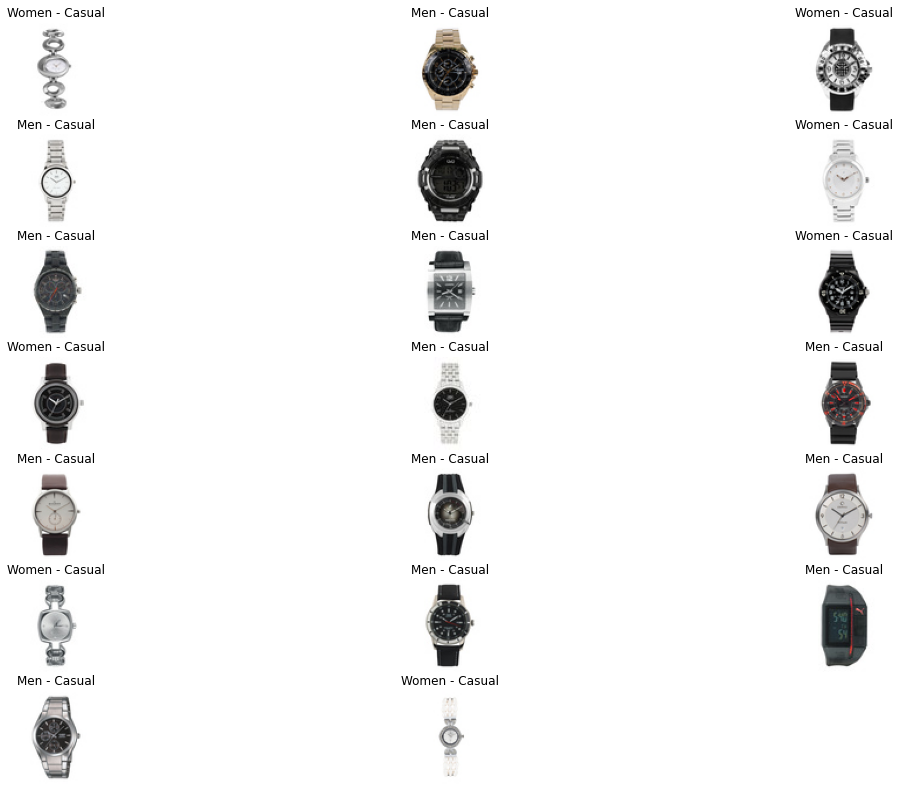

In [9]:
from math import ceil
# set for the number of image you want to see
sample_to_show = 20

sample = np.random.permutation(image_paths)[:sample_to_show]
fig = plt.figure(figsize=(20, 14))
columns = 3
rows = ceil(sample_to_show/columns)
for i, smpl in enumerate(sample):
    fig.add_subplot(rows, columns, i+1)
    id_ = smpl.split(os.sep)[-1][:-4]
    st = STYLES[id_]
    plt.imshow(load_img(smpl))
    plt.axis('off')
    plt.title(f"{st['gender']} - {st['usage']}")

## Building model

In [10]:
# Build neural network function
def build_network(width, height, depth, classes):
    input_layer = Input(shape=(width, height, depth))
    
    x = Conv2D(filters=32, kernel_size=(3, 3), padding="same")(input_layer)
    x = ReLU()(x)
    x = BatchNormalization(axis=-1)(x)
    x = Conv2D(filters=32, kernel_size=(3, 3), padding="same")(x)
    x = ReLU()(x)
    x = BatchNormalization(axis=-1)(x)
    x = MaxPooling2D(pool_size=(2,2))(x)
    x = Dropout(rate=.25)(x)
    
    x = Conv2D(filters=64, kernel_size=(3, 3), padding="same")(x)
    x = ReLU()(x)
    x = BatchNormalization(axis=-1)(x)
    x = Conv2D(filters=64, kernel_size=(3, 3), padding="same")(x)
    x = ReLU()(x)
    x = BatchNormalization(axis=-1)(x)
    x = MaxPooling2D(pool_size=(2,2))(x)
    x = Dropout(rate=.25)(x)
    
    x = Flatten()(x)
    x = Dense(units=512)(x)
    x = ReLU()(x)
    x = BatchNormalization(axis=-1)(x)
    x = Dropout(rate=.25)(x)
    x = Dense(units=classes)(x)
    output = Activation('sigmoid')(x)
    
    return Model(input_layer, output)

In [11]:
width, height , depth =(64, 64, 3) 
model = build_network(width, height , depth, len(mlb.classes_))
model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

## Train and test the model

In [12]:
BATCH_SIZE = 64
EPOCHS = 20
history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), batch_size=BATCH_SIZE, epochs=EPOCHS)

Epoch 1/20
24/24 [==============================] - 25s 1s/step - loss: 0.6544 - accuracy: 0.1612 - val_loss: 0.7353 - val_accuracy: 0.0557
Epoch 2/20
24/24 [==============================] - 26s 1s/step - loss: 0.3948 - accuracy: 0.2395 - val_loss: 0.7275 - val_accuracy: 0.9416
Epoch 3/20
24/24 [==============================] - 26s 1s/step - loss: 0.2681 - accuracy: 0.4300 - val_loss: 0.6142 - val_accuracy: 0.9814
Epoch 4/20
24/24 [==============================] - 26s 1s/step - loss: 0.1853 - accuracy: 0.5269 - val_loss: 0.8367 - val_accuracy: 0.9814
Epoch 5/20
24/24 [==============================] - 26s 1s/step - loss: 0.1502 - accuracy: 0.6490 - val_loss: 0.5740 - val_accuracy: 0.9814
Epoch 6/20
24/24 [==============================] - 26s 1s/step - loss: 0.1262 - accuracy: 0.6709 - val_loss: 0.4952 - val_accuracy: 0.9814
Epoch 7/20
24/24 [==============================] - 26s 1s/step - loss: 0.1101 - accuracy: 0.6749 - val_loss: 0.4418 - val_accuracy: 0.9814
Epoch 8/20
24/24 [==

In [13]:
def plot_model_history(model_history, metric, ylim=None):
    plt.style.use('seaborn-darkgrid')
    plt.plot(model_history[metric])
    plt.title(metric.upper())
    plt.show()

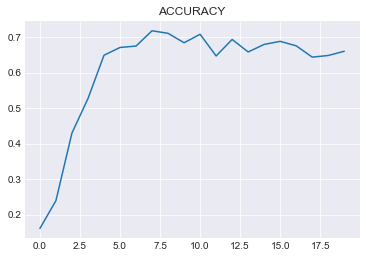

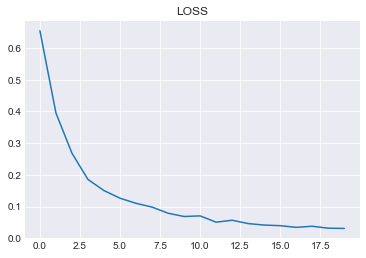

In [14]:
plot_model_history(history.history, 'accuracy')
plot_model_history(history.history, 'loss')

In [15]:
result = model.evaluate(X_test, y_test, batch_size=BATCH_SIZE)
print(f"Test accuracy: {result[1]*100:.2f}%")

8/8 [==============================] - 1s 118ms/step - loss: 0.3885 - accuracy: 0.9172
Test accuracy: 91.72%


In [69]:
## Test with your own watch image
def load_test_image(img_path):
    image = load_img(img_path, target_size=(width, height, depth))
    image = img_to_array(image) / 255.
    return np.expand_dims(image, axis=0)

Casual: 100.00%
Formal: 0.00%
Men: 90.29%
Smart Casual: 0.00%
Women: 0.14%


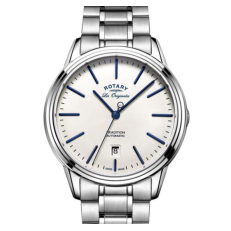

In [82]:
image_path = (base_path / 'test1.jpg')
image = load_test_image(image_path)
probabilities = model.predict(image)[0]
for label, p in zip(mlb.classes_, probabilities):
    print(f'{label}: {p * 100:.2f}%')
plt.imshow(load_img(image_path))
plt.axis("off")
plt.show()